In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


input/fer2013.csv


In [3]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install keras


Note: you may need to restart the kernel to use updated packages.


In [1]:
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# from keras.utils import np_utils

In [2]:
df = pd.read_csv('input/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [4]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happy', 4: 'sad', 5: 'surprise', 6: 'neutral'}

In [5]:
df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

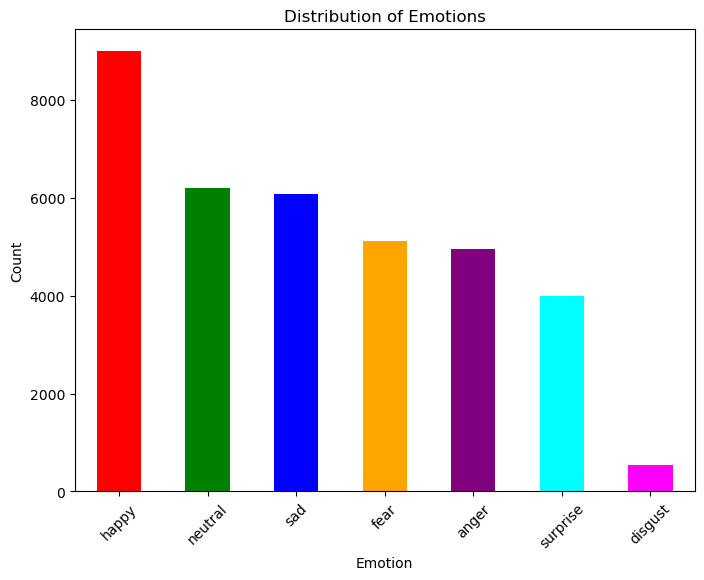

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your DataFrame
emotion_counts = df['emotion'].value_counts()

# Define colors for each emotion
colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'magenta']

# Define emotion labels
emotion_labels = {0:'anger', 1:'disgust', 2:'fear', 3:'happy', 4: 'sad', 5: 'surprise', 6: 'neutral'}

# Map numeric labels to emotion names
emotion_counts.index = emotion_counts.index.map(emotion_labels)

# Create a bar plot
plt.figure(figsize=(8, 6))
emotion_counts.plot(kind='bar', color=colors)
plt.title('Distribution of Emotions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.show()

In [7]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

/var/folders/z3/_lf6f9cj6bx9_46lj_sjr11w0000gn/T/ipykernel_62263/2088611314.py:15: UserWarning: The figure layout has changed to tight
  pyplot.tight_layout()


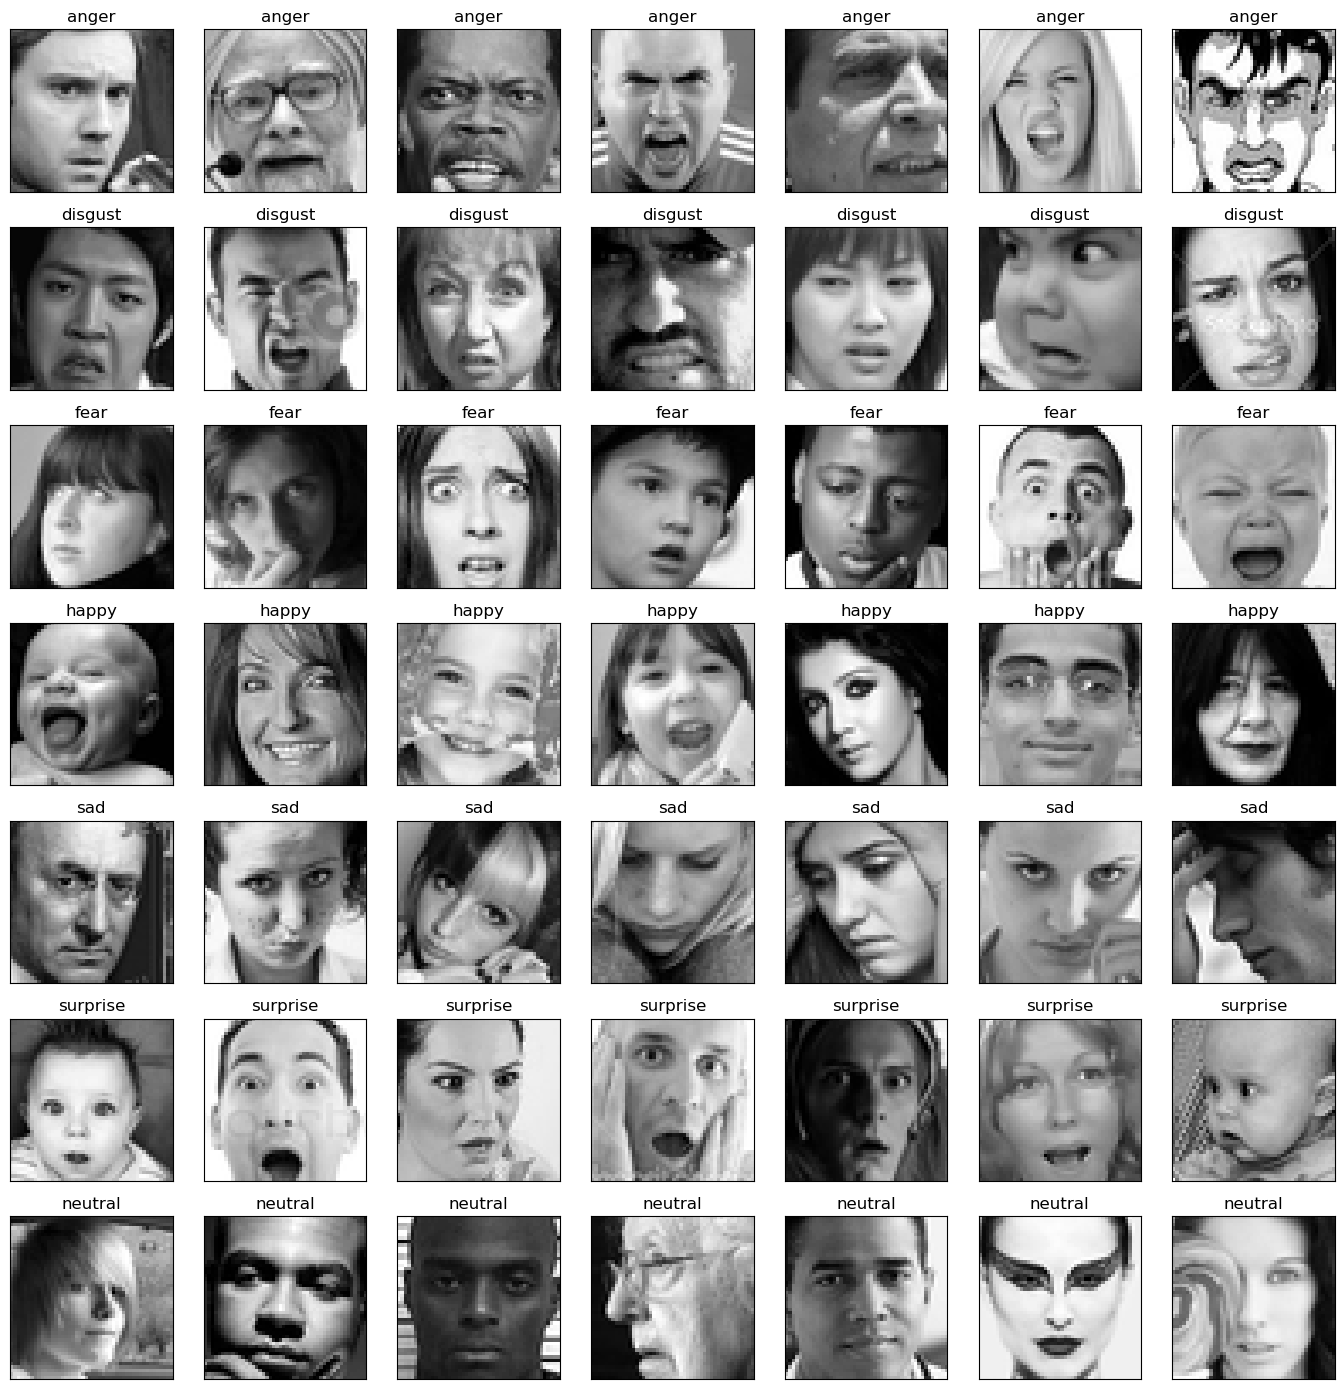

In [10]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [18]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [19]:
img_array.shape

(35887, 48, 48, 1)

In [22]:
from keras.utils import to_categorical
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [23]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,shuffle=True, stratify=img_labels,test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 1), (3589, 48, 48, 1), (32298, 7), (3589, 7))

In [ ]:
from imblearn.over_sampling import SMOTE

# Assuming `X_train` and `y_train` are your training data and labels respectively

# Reshape X_train if necessary (e.g., for SMOTE)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

# Initialize SMOTE for oversampling
smote = SMOTE(random_state=42)

# Perform oversampling
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train_reshaped, y_train)

# Reshape X_train_oversampled back to its original shape
X_train_oversampled = X_train_oversampled.reshape(-1, img_width, img_height, img_depth)

# Now X_train_oversampled and y_train_oversampled contain the oversampled data


In [25]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [26]:
X_train = X_train / 255.
X_valid = X_valid / 255.

In [27]:
def build_net(optim):
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [28]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [29]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [33]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

model = build_net(optims[1]) 
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    callbacks=callbacks,
#     use_multiprocessing=True
)

Model: "DCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1 (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_4                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2 (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_5                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_6                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_3 (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_7                     │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,395,591 (9.14 MB)

 Trainable params: 2,393,543 (9.13 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/100


/Users/saisanjanapithani/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 455s 449ms/step - accuracy: 0.2036 - loss: 2.3975 - val_accuracy: 0.3600 - val_loss: 1.6272 - learning_rate: 0.0010
Epoch 2/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 7:34 450ms/step - accuracy: 0.2812 - loss: 1.5641

2024-04-23 11:58:38.892208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/saisanjanapithani/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.2812 - loss: 1.5641 - val_accuracy: 0.3644 - val_loss: 1.6236 - learning_rate: 0.0010
Epoch 3/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 538s 533ms/step - accuracy: 0.3315 - loss: 1.6854 - val_accuracy: 0.4369 - val_loss: 1.4688 - learning_rate: 0.0010
Epoch 4/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 9:02 538ms/step - accuracy: 0.3438 - loss: 1.7048

2024-04-23 12:07:51.486199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.3438 - loss: 1.7048 - val_accuracy: 0.4383 - val_loss: 1.4517 - learning_rate: 0.0010
Epoch 5/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 593s 588ms/step - accuracy: 0.4094 - loss: 1.5182 - val_accuracy: 0.4868 - val_loss: 1.3597 - learning_rate: 0.0010
Epoch 6/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 10:02 598ms/step - accuracy: 0.4375 - loss: 1.4162

2024-04-23 12:18:02.493850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.4375 - loss: 1.4162 - val_accuracy: 0.4893 - val_loss: 1.3644 - learning_rate: 0.0010
Epoch 7/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 565s 560ms/step - accuracy: 0.4620 - loss: 1.4075 - val_accuracy: 0.5054 - val_loss: 1.3114 - learning_rate: 0.0010
Epoch 8/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 9:15 551ms/step - accuracy: 0.4688 - loss: 1.2791

2024-04-23 12:27:46.297260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.4688 - loss: 1.2791 - val_accuracy: 0.5068 - val_loss: 1.3059 - learning_rate: 0.0010
Epoch 9/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 901s 893ms/step - accuracy: 0.4931 - loss: 1.3311 - val_accuracy: 0.5620 - val_loss: 1.1534 - learning_rate: 0.0010
Epoch 10/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 7:40 457ms/step - accuracy: 0.5000 - loss: 1.4937

2024-04-23 12:43:04.234319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.5000 - loss: 1.4937 - val_accuracy: 0.5631 - val_loss: 1.1503 - learning_rate: 0.0010
Epoch 11/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 578s 573ms/step - accuracy: 0.5122 - loss: 1.2830 - val_accuracy: 0.5444 - val_loss: 1.1898 - learning_rate: 0.0010
Epoch 12/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 8:56 533ms/step - accuracy: 0.5000 - loss: 1.4504

2024-04-23 12:52:56.685517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.5000 - loss: 1.4504 - val_accuracy: 0.5467 - val_loss: 1.1845 - learning_rate: 0.0010
Epoch 13/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 608s 602ms/step - accuracy: 0.5281 - loss: 1.2470 - val_accuracy: 0.5598 - val_loss: 1.1590 - learning_rate: 0.0010
Epoch 14/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 9:52 587ms/step - accuracy: 0.6250 - loss: 0.8348

2024-04-23 13:03:21.796790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.6250 - loss: 0.8348 - val_accuracy: 0.5600 - val_loss: 1.1583 - learning_rate: 0.0010
Epoch 15/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 630s 625ms/step - accuracy: 0.5451 - loss: 1.2127 - val_accuracy: 0.5988 - val_loss: 1.0637 - learning_rate: 0.0010
Epoch 16/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 8:47 523ms/step - accuracy: 0.6250 - loss: 1.0100

2024-04-23 13:14:11.776225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.6250 - loss: 1.0100 - val_accuracy: 0.5977 - val_loss: 1.0628 - learning_rate: 0.0010
Epoch 17/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 633s 628ms/step - accuracy: 0.5556 - loss: 1.1861 - val_accuracy: 0.6113 - val_loss: 1.0378 - learning_rate: 0.0010
Epoch 18/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 10:25 621ms/step - accuracy: 0.5000 - loss: 1.1737

2024-04-23 13:25:02.990788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.5000 - loss: 1.1737 - val_accuracy: 0.6108 - val_loss: 1.0393 - learning_rate: 0.0010
Epoch 19/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 633s 628ms/step - accuracy: 0.5653 - loss: 1.1670 - val_accuracy: 0.5812 - val_loss: 1.0813 - learning_rate: 0.0010
Epoch 20/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 9:25 561ms/step - accuracy: 0.5000 - loss: 1.4935

2024-04-23 13:35:56.638123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.5000 - loss: 1.4935 - val_accuracy: 0.5798 - val_loss: 1.0822 - learning_rate: 0.0010
Epoch 21/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 678s 672ms/step - accuracy: 0.5692 - loss: 1.1538 - val_accuracy: 0.6197 - val_loss: 1.0253 - learning_rate: 0.0010
Epoch 22/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 10:44 640ms/step - accuracy: 0.6250 - loss: 1.3724

2024-04-23 13:47:34.065481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.6250 - loss: 1.3724 - val_accuracy: 0.6188 - val_loss: 1.0265 - learning_rate: 0.0010
Epoch 23/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 712s 706ms/step - accuracy: 0.5796 - loss: 1.1319 - val_accuracy: 0.6183 - val_loss: 1.0226 - learning_rate: 0.0010
Epoch 24/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 11:22 677ms/step - accuracy: 0.6875 - loss: 1.0125

2024-04-23 13:59:46.409432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.6875 - loss: 1.0125 - val_accuracy: 0.6160 - val_loss: 1.0251 - learning_rate: 0.0010
Epoch 25/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 725s 719ms/step - accuracy: 0.5829 - loss: 1.1137 - val_accuracy: 0.6247 - val_loss: 0.9949 - learning_rate: 0.0010
Epoch 26/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 9:59 595ms/step - accuracy: 0.5000 - loss: 1.1727

2024-04-23 14:12:14.032095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.5000 - loss: 1.1727 - val_accuracy: 0.6247 - val_loss: 0.9945 - learning_rate: 0.0010
Epoch 27/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 663s 657ms/step - accuracy: 0.5860 - loss: 1.1011 - val_accuracy: 0.6336 - val_loss: 0.9719 - learning_rate: 0.0010
Epoch 28/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 9:00 536ms/step - accuracy: 0.5625 - loss: 1.1518

2024-04-23 14:23:37.260021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.5625 - loss: 1.1518 - val_accuracy: 0.6339 - val_loss: 0.9727 - learning_rate: 0.0010
Epoch 29/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 598s 592ms/step - accuracy: 0.5956 - loss: 1.0860 - val_accuracy: 0.6266 - val_loss: 1.0106 - learning_rate: 0.0010
Epoch 30/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 9:24 560ms/step - accuracy: 0.4688 - loss: 1.2580

2024-04-23 14:33:52.064126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.4688 - loss: 1.2580 - val_accuracy: 0.6300 - val_loss: 1.0076 - learning_rate: 0.0010
Epoch 31/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 606s 601ms/step - accuracy: 0.5981 - loss: 1.0785 - val_accuracy: 0.6347 - val_loss: 0.9778 - learning_rate: 0.0010
Epoch 32/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 9:31 567ms/step - accuracy: 0.5938 - loss: 1.0730

2024-04-23 14:44:18.002790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.5938 - loss: 1.0730 - val_accuracy: 0.6330 - val_loss: 0.9781 - learning_rate: 0.0010
Epoch 33/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 603s 598ms/step - accuracy: 0.5972 - loss: 1.0763 - val_accuracy: 0.6328 - val_loss: 0.9953 - learning_rate: 0.0010
Epoch 34/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 9:43 579ms/step - accuracy: 0.5000 - loss: 1.3024

2024-04-23 14:54:39.809365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.5000 - loss: 1.3024 - val_accuracy: 0.6322 - val_loss: 0.9930 - learning_rate: 0.0010
Epoch 35/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 614s 608ms/step - accuracy: 0.6065 - loss: 1.0608 - val_accuracy: 0.6395 - val_loss: 0.9723 - learning_rate: 0.0010
Epoch 36/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 9:25 561ms/step - accuracy: 0.7500 - loss: 0.8046

2024-04-23 15:05:12.955808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.7500 - loss: 0.8046 - val_accuracy: 0.6403 - val_loss: 0.9736 - learning_rate: 0.0010
Epoch 37/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 640s 635ms/step - accuracy: 0.6044 - loss: 1.0671 - val_accuracy: 0.6489 - val_loss: 0.9445 - learning_rate: 0.0010
Epoch 38/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 7:21 438ms/step - accuracy: 0.6250 - loss: 0.9273

2024-04-23 15:16:11.517467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.6250 - loss: 0.9273 - val_accuracy: 0.6495 - val_loss: 0.9458 - learning_rate: 0.0010
Epoch 39/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 560s 556ms/step - accuracy: 0.6145 - loss: 1.0333 - val_accuracy: 0.6486 - val_loss: 0.9390 - learning_rate: 0.0010
Epoch 40/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 8:05 482ms/step - accuracy: 0.6875 - loss: 0.9655

2024-04-23 15:25:46.023046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.6875 - loss: 0.9655 - val_accuracy: 0.6484 - val_loss: 0.9375 - learning_rate: 0.0010
Epoch 41/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 541s 536ms/step - accuracy: 0.6159 - loss: 1.0383 - val_accuracy: 0.6484 - val_loss: 0.9491 - learning_rate: 0.0010
Epoch 42/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 8:38 515ms/step - accuracy: 0.6250 - loss: 0.9839

2024-04-23 15:35:02.666381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.6250 - loss: 0.9839 - val_accuracy: 0.6492 - val_loss: 0.9488 - learning_rate: 0.0010
Epoch 43/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 544s 539ms/step - accuracy: 0.6202 - loss: 1.0313 - val_accuracy: 0.6417 - val_loss: 0.9870 - learning_rate: 0.0010
Epoch 44/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 8:32 508ms/step - accuracy: 0.7188 - loss: 0.8280

2024-04-23 15:44:23.876181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.7188 - loss: 0.8280 - val_accuracy: 0.6403 - val_loss: 0.9860 - learning_rate: 0.0010
Epoch 45/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.6124 - loss: 1.0411
Epoch 45: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 560s 555ms/step - accuracy: 0.6124 - loss: 1.0410 - val_accuracy: 0.6489 - val_loss: 0.9520 - learning_rate: 0.0010
Epoch 46/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 8:24 501ms/step - accuracy: 0.6562 - loss: 0.8280

2024-04-23 15:54:00.580857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.6562 - loss: 0.8280 - val_accuracy: 0.6498 - val_loss: 0.9512 - learning_rate: 5.0000e-04
Epoch 47/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 563s 558ms/step - accuracy: 0.6227 - loss: 1.0069 - val_accuracy: 0.6640 - val_loss: 0.9651 - learning_rate: 5.0000e-04
Epoch 48/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 8:24 501ms/step - accuracy: 0.6562 - loss: 0.9422

2024-04-23 16:03:40.214616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.6562 - loss: 0.9422 - val_accuracy: 0.6651 - val_loss: 0.9651 - learning_rate: 5.0000e-04
Epoch 49/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 589s 584ms/step - accuracy: 0.6324 - loss: 0.9918 - val_accuracy: 0.6687 - val_loss: 0.9142 - learning_rate: 5.0000e-04
Epoch 50/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 9:33 569ms/step - accuracy: 0.5625 - loss: 1.2246

2024-04-23 16:13:45.379674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.5625 - loss: 1.2246 - val_accuracy: 0.6682 - val_loss: 0.9148 - learning_rate: 5.0000e-04
Epoch 51/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 592s 586ms/step - accuracy: 0.6297 - loss: 0.9992 - val_accuracy: 0.6673 - val_loss: 0.9101 - learning_rate: 5.0000e-04
Epoch 52/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 9:36 572ms/step - accuracy: 0.6250 - loss: 0.8381

2024-04-23 16:23:55.777165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.6250 - loss: 0.8381 - val_accuracy: 0.6670 - val_loss: 0.9101 - learning_rate: 5.0000e-04
Epoch 53/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 579s 574ms/step - accuracy: 0.6382 - loss: 0.9779 - val_accuracy: 0.6762 - val_loss: 0.9114 - learning_rate: 5.0000e-04
Epoch 54/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 9:00 536ms/step - accuracy: 0.8438 - loss: 0.7205

2024-04-23 16:33:54.220249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.8438 - loss: 0.7205 - val_accuracy: 0.6760 - val_loss: 0.9117 - learning_rate: 5.0000e-04
Epoch 55/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 565s 560ms/step - accuracy: 0.6483 - loss: 0.9622 - val_accuracy: 0.6537 - val_loss: 0.9438 - learning_rate: 5.0000e-04
Epoch 56/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 9:28 564ms/step - accuracy: 0.7188 - loss: 0.7197

2024-04-23 16:43:36.467499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.7188 - loss: 0.7197 - val_accuracy: 0.6539 - val_loss: 0.9428 - learning_rate: 5.0000e-04
Epoch 57/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 576s 571ms/step - accuracy: 0.6367 - loss: 0.9799 - val_accuracy: 0.6673 - val_loss: 0.9066 - learning_rate: 5.0000e-04
Epoch 58/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 9:00 536ms/step - accuracy: 0.6250 - loss: 0.9905

2024-04-23 16:53:30.909755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.6250 - loss: 0.9905 - val_accuracy: 0.6662 - val_loss: 0.9068 - learning_rate: 5.0000e-04
Epoch 59/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 584s 579ms/step - accuracy: 0.6390 - loss: 0.9718 - val_accuracy: 0.6709 - val_loss: 0.9108 - learning_rate: 5.0000e-04
Epoch 60/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 9:17 553ms/step - accuracy: 0.7188 - loss: 0.8094

2024-04-23 17:03:32.915082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 60: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.7188 - loss: 0.8094 - val_accuracy: 0.6698 - val_loss: 0.9105 - learning_rate: 5.0000e-04
Epoch 61/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 587s 581ms/step - accuracy: 0.6480 - loss: 0.9499 - val_accuracy: 0.6726 - val_loss: 0.9012 - learning_rate: 2.5000e-04
Epoch 62/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 9:05 541ms/step - accuracy: 0.5312 - loss: 1.1196

2024-04-23 17:13:37.642037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.5312 - loss: 1.1196 - val_accuracy: 0.6726 - val_loss: 0.9009 - learning_rate: 2.5000e-04
Epoch 63/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 554s 549ms/step - accuracy: 0.6551 - loss: 0.9359 - val_accuracy: 0.6729 - val_loss: 0.8889 - learning_rate: 2.5000e-04
Epoch 64/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 8:33 510ms/step - accuracy: 0.6875 - loss: 0.9915

2024-04-23 17:23:09.121884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.6875 - loss: 0.9915 - val_accuracy: 0.6737 - val_loss: 0.8888 - learning_rate: 2.5000e-04
Epoch 64: early stopping
Restoring model weights from the end of the best epoch: 53.


In [34]:
test_loss, test_accuracy = model.evaluate(x=X_valid, y=y_valid)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - accuracy: 0.6787 - loss: 0.8899
Test Loss: 0.911414623260498
Test Accuracy: 0.6762329339981079


In [35]:
model_json = model.to_json()
with open("emotiondetector.json",'w') as json_file:
    json_file.write(model_json)
model.save("emotiondetector.h5")

In [36]:
from keras.models import model_from_json

In [37]:
json_file = open("emotiondetector.json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Load the model weights into the loaded model
loaded_model.load_weights("emotiondetector.h5")

/var/folders/z3/_lf6f9cj6bx9_46lj_sjr11w0000gn/T/ipykernel_3332/2568655633.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


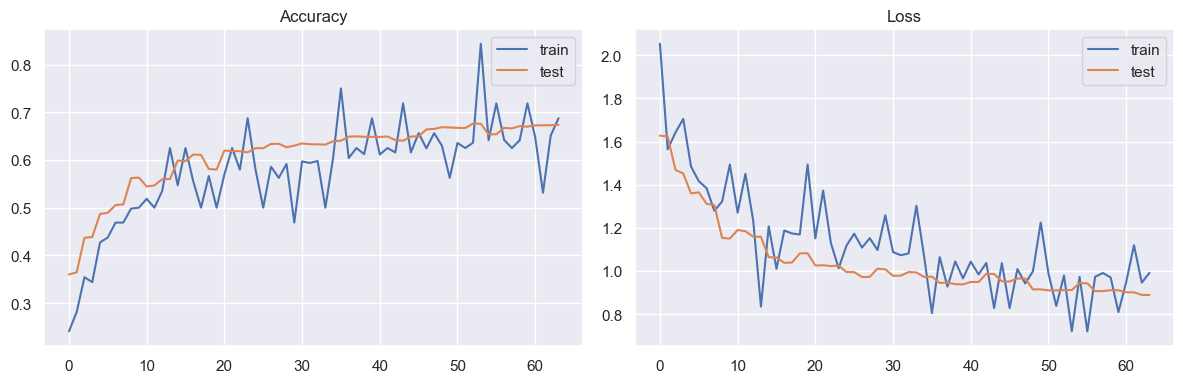

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='test')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='test')
plt.title('Loss')
plt.tight_layout()

plt.savefig('epoch_history_dcnn.png')
plt.show()

/var/folders/z3/_lf6f9cj6bx9_46lj_sjr11w0000gn/T/ipykernel_3332/1952070991.py:13: UserWarning: The figure layout has changed to tight
  pyplot.tight_layout()


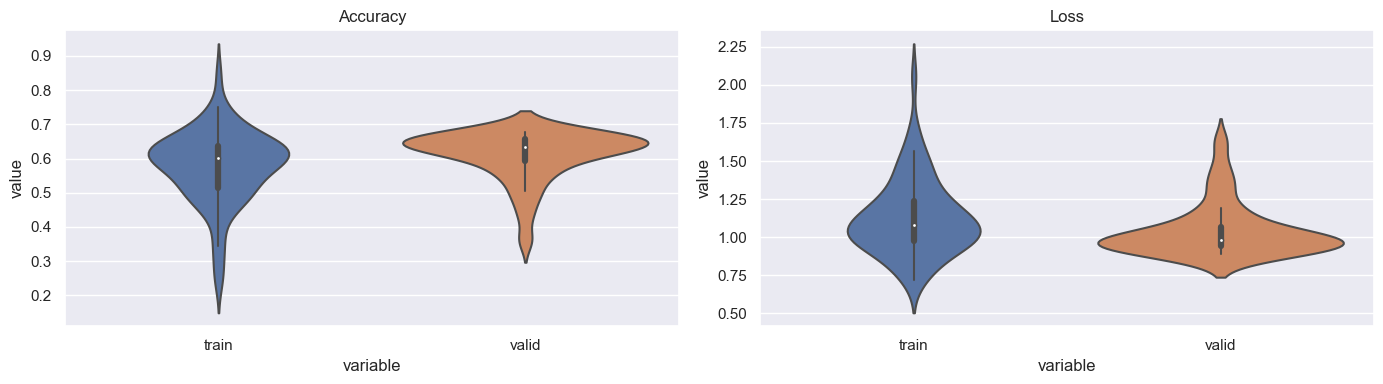

In [40]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()


113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step
total wrong validation predictions: 1162


              precision    recall  f1-score   support

           0       0.60      0.64      0.62       495
           1       0.83      0.35      0.49        55
           2       0.60      0.38      0.46       512
           3       0.87      0.87      0.87       899
           4       0.58      0.53      0.55       608
           5       0.74      0.79      0.76       400
           6       0.58      0.77      0.66       620

    accuracy                           0.68      3589
   macro avg       0.68      0.62      0.63      3589
weighted avg       0.68      0.68      0.67      3589



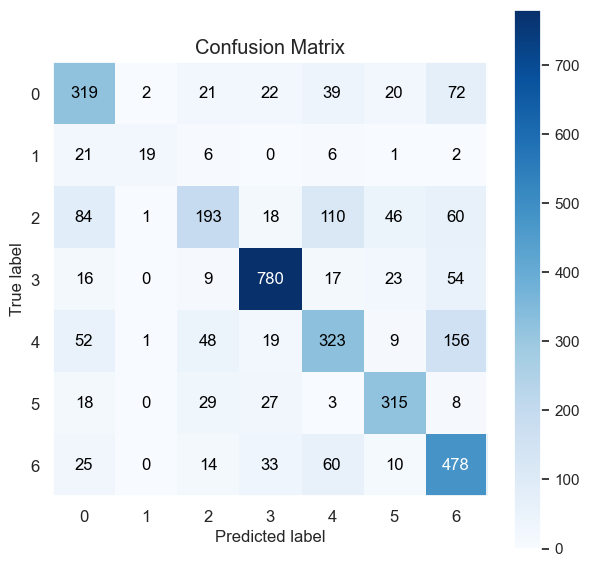

In [44]:
yhat_valid_probs = model.predict(X_valid)
yhat_valid_classes = yhat_valid_probs.argmax(axis=1)

scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid_classes, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid_classes)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid_classes))

In [45]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

model2 = build_net(optims[0]) 
history = model2.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    callbacks=callbacks,
#     use_multiprocessing=True
)

/Users/saisanjanapithani/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "DCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1 (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_4                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2 (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_5                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_6                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_3 (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_7                     │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,395,591 (9.14 MB)

 Trainable params: 2,393,543 (9.13 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/100


/Users/saisanjanapithani/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 486s 480ms/step - accuracy: 0.2063 - loss: 2.4275 - val_accuracy: 0.3527 - val_loss: 1.6346 - learning_rate: 0.0010
Epoch 2/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 8:58 534ms/step - accuracy: 0.2500 - loss: 1.9399

2024-04-23 19:18:27.839622: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/saisanjanapithani/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.2500 - loss: 1.9399 - val_accuracy: 0.3533 - val_loss: 1.6375 - learning_rate: 0.0010
Epoch 3/100
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 541s 536ms/step - accuracy: 0.3248 - loss: 1.7045 - val_accuracy: 0.4207 - val_loss: 1.4883 - learning_rate: 0.0010
Epoch 4/100
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 9:35 571ms/step - accuracy: 0.4375 - loss: 1.5179

2024-04-23 19:27:45.120063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.4375 - loss: 1.5179 - val_accuracy: 0.4174 - val_loss: 1.4906 - learning_rate: 0.0010
Epoch 5/100
 972/1009 ━━━━━━━━━━━━━━━━━━━━ 21s 584ms/step - accuracy: 0.4082 - loss: 1.5238

KeyboardInterrupt: 

In [46]:
test_loss2, test_accuracy2 = model2.evaluate(x=X_valid, y=y_valid)
print("Test Loss:", test_loss2)
print("Test Accuracy:", test_accuracy2)

113/113 ━━━━━━━━━━━━━━━━━━━━ 13s 114ms/step - accuracy: 0.5154 - loss: 1.2793
Test Loss: 1.2759732007980347
Test Accuracy: 0.5132349133491516
